# Representational Geodesic

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pyrtools as pt
import plenoptic as po

%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision import models

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype  = torch.float32
torch.__version__

'1.6.0'

## Fourier magnitude demo

Computing a geodesic to reveal excess invariance of the global Fourier magnitude representation.

In [2]:
einstein = po.make_basic_stimuli(256, requires_grad=False)[-1]

n_steps = 11
vid = torch.empty(n_steps, *einstein.shape)

vid[0] = einstein
for shift in range(1, n_steps):
    vid[shift] = torch.roll(einstein, shift, [2])

c = 64
vid = vid[...,c:-c, c:-c]
vid = po.rescale(vid, 0, 1)

imgA = vid[0:1]
imgB = vid[-1:]

pt.image_stats(po.to_numpy(imgA))
pt.image_stats(po.to_numpy(imgB))
print(imgA.shape)
print(vid.shape)

# convention: full name for numpy arrays, short hands for torch tensors
video = po.to_numpy(vid).squeeze()
print(video.shape)
pt.animshow(video, zoom=2)

Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.469115,  Stdev: 0.165756,  Kurtosis: 3.675402
Image statistics:
  Range: [0.000000, 1.000000]
  Mean: 0.480635,  Stdev: 0.165142,  Kurtosis: 3.627025
torch.Size([1, 1, 128, 128])
torch.Size([11, 1, 128, 128])
(11, 128, 128)


In [3]:
class Fourier(nn.Module):
    def __init__(self, representation = 'amp'):
        super().__init__()
        self.representation = representation
    def fourier(self, x):
        return torch.rfft(x, 2)

    def forward(self, x):
        if self.representation == 'amp':
            return po.rectangular_to_polar( *self.fourier(x).unbind(-1) )[0]
        elif self.representation == 'amp_phase':            
            return torch.cat(po.rectangular_to_polar( *self.fourier(x).unbind(-1) ), 1)

fourier_amp = Fourier('amp')

In [4]:
moog = po.synth.Geodesic(imgA, imgB, fourier_amp, len(video), init='straight', lmbda=.1)
moog.synthesize(230)

geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()

100%|██████████| 230/230 [00:04<00:00, 57.21it/s, loss=5.2215e-05, gradient norm=1.7974e-02, lr=0.001]


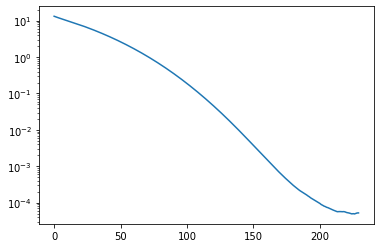

In [5]:
plt.semilogy(moog.loss)

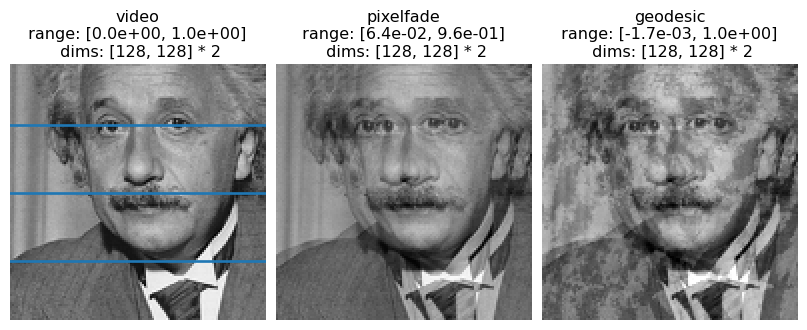

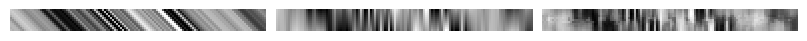

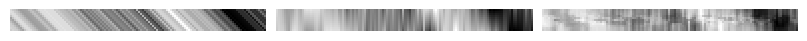

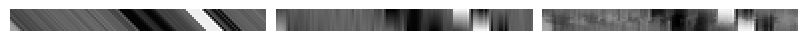

In [6]:
fig = pt.imshow([video[5], pixelfade[5], geodesic[5]],
          title=['video', 'pixelfade', 'geodesic'],
          col_wrap=3, zoom=2);

h = 98
m = 64
l = 30

# for a in fig.get_axes()[0]:
a = fig.get_axes()[0]
for line in (h, m, l):
    a.axhline(line, lw=2)


pt.imshow([video[:,l], pixelfade[:,l], geodesic[:,l]],
          title=None, col_wrap=3, zoom=2);
pt.imshow([video[:,m], pixelfade[:,m], geodesic[:,m]],
          title=None, col_wrap=3, zoom=2);
pt.imshow([video[:,h], pixelfade[:,h], geodesic[:,h]],
          title=None, col_wrap=3, zoom=2);

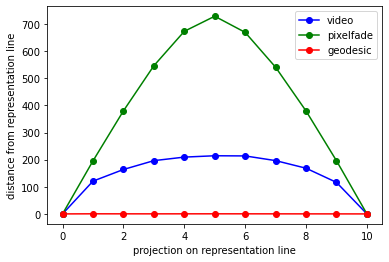

In [7]:
moog.plot_distance_from_line(vid)

## Vision models demo

In [18]:
model = po.simul.Polar_Pyramid(imgB.shape[-2:])


# TODO
# - speedup front_end -> LGN V1 -> complex
# model = po.simul.Steerable_GainControl(imgB.shape[-2:], is_complex=True,
# n_ori=4, n_scale=5, residuals=False, front_end=True).eval()

In [19]:
with torch.no_grad():
    yA = model(imgA)
    yB = model(imgB)
imgA.requires_grad, yA.requires_grad

(False, False)

In [20]:
# %debug

In [21]:
yA.shape, yA.numel()

(torch.Size([1, 32, 128, 128]), 524288)

In [22]:
n_steps = len(video)
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight', lmbda=.1)

print('shape trainable param', '# trainable param')
#  sum(p.numel() for p in moog.parameters())
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

shape trainable param # trainable param


([torch.Size([9, 1, 128, 128])], 147456)

In [23]:
moog.synthesize()

100%|██████████| 1000/1000 [20:38<00:00,  1.24s/it, loss=5.7333e+01, gradient norm=9.2534e+00, lr=0.001]


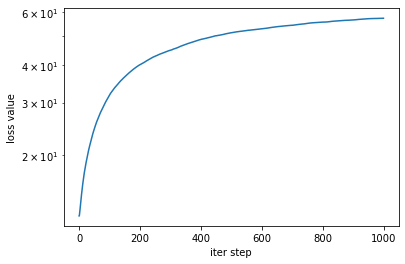

In [24]:
plt.semilogy(moog.loss)
plt.xlabel('iter step')
plt.ylabel('loss value')
# plt.ylim([1e-1, .5])
plt.show()

In [25]:
geodesic  = po.to_numpy(moog.geodesic).squeeze()
pixelfade = po.to_numpy(moog.pixelfade).squeeze()
geodesic.shape, pixelfade.shape

((11, 128, 128), (11, 128, 128))

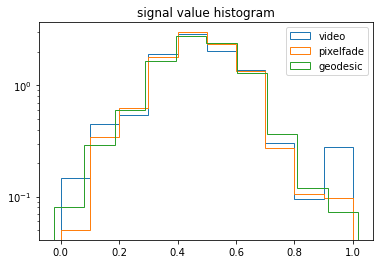

In [26]:
# checking that the range constraint is met
plt.hist(video.flatten(), histtype='step', density=True, label='video')
plt.hist(pixelfade.flatten(), histtype='step', density=True, label='pixelfade')
plt.hist(geodesic.flatten(), histtype='step', density=True, label='geodesic');
plt.yscale('log')
plt.title('signal value histogram')
plt.legend(loc=1)
plt.show()

In [8]:
print('geodesic')
pt.imshow(geodesic, vrange='auto1', title=None);
print('diff')
pt.imshow(geodesic - pixelfade, vrange='auto1', title=None);
print('pixelfade')
pt.imshow(pixelfade, vrange='auto1', title=None);

geodesic


Exception: Can't figure out how to plot image with shape (11, 128, 128)as RGB(A)! RGB(A) signals should have their finaldimension of shape 3 or 4.

In [20]:
# pt.animshow(geodesic, framerate=10, zoom=1, repeat=True)
# pt.animshow(geodesic - pixelfade, vrange='auto1')

In [21]:
pt.animshow([geodesic, pixelfade], 
            title=['geodesic', 'pixelfade'], vrange='indep1',
            framerate=10, zoom=1, repeat=True)


 video 
 pixelfade 
 geodesic


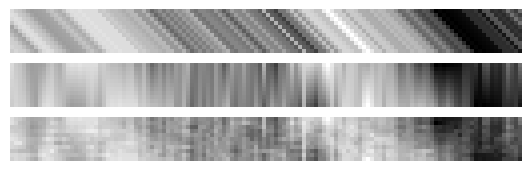

In [22]:
# horizontal slice

print('\n video', '\n pixelfade', '\n geodesic')
pt.imshow([video[:,64], pixelfade[:,64], geodesic[:,64]],
          title=None, col_wrap=1, zoom=4);

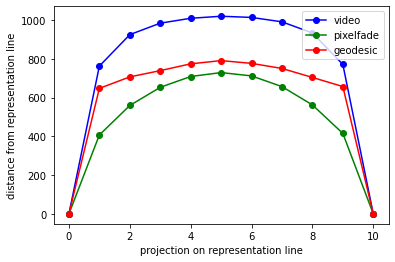

In [23]:
# Deviation from the straight line

plt.plot(po.to_numpy(moog.distance_from_line(vid)), 'b-o', label='video')
plt.plot(po.to_numpy(moog.distance_from_line(moog.pixelfade)), 'g-o', label='pixelfade')
plt.plot(po.to_numpy(moog.distance_from_line(moog.geodesic)), 'r-o', label='geodesic')
plt.legend(loc=1)
plt.ylabel('distance from representation line')
plt.xlabel('projection on representation line')
# plt.yscale('log')
plt.show()

In [43]:
from IPython.display import HTML
from matplotlib import animation

fig, ax = plt.subplots()
ax.plot(po.to_numpy(moog.distance_from_line(vid)), 'b-o', label='video')
ax.plot(po.to_numpy(moog.distance_from_line(moog.pixelfade)), 'g-o', label='pixelfade')
artist, = ax.plot(po.to_numpy(moog.distance_from_line(moog.geodesic)), 'r-o', label='geodesic')
plt.legend(loc=1)
plt.ylabel('distance from representation line')
plt.xlabel('projection on representation line');
# plt.yscale('log')

def animate(i):

    artist.set_data(range(11), po.to_numpy(moog.dist_from_line[i]).squeeze())
#     artist.
    return (artist,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=100, interval=20, blit=True, repeat=False)
anim = HTML(anim.to_html5_video())
plt.close()

anim

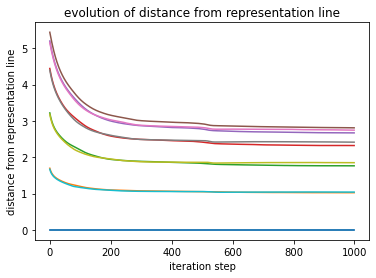

In [44]:
plt.plot(torch.cat(moog.dist_from_line, 0))

plt.title('evolution of distance from representation line')
plt.ylabel('distance from representation line')
plt.xlabel('iteration step')
# plt.yscale('log')
plt.show()

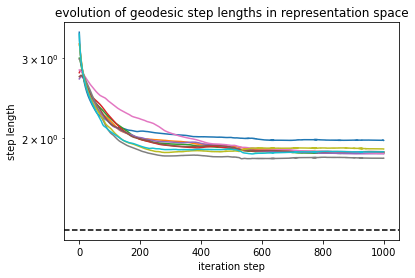

In [45]:
step_lengths = torch.cat(moog.step_lengths, dim=0)
# plt.plot(step_lengths[:, 0], 'r--');
plt.plot(step_lengths);
plt.axhline(po.to_numpy(moog.reference_length / (moog.n_steps - 1)), ls='--', c='k')

plt.xlabel('iteration step')
plt.ylabel('step length')
plt.title('evolution of geodesic step lengths in representation space')

plt.yscale('log')
# plt.ylim([0,2])
# plt.xlim([0,40])
plt.show()

In [46]:
# representation plot

# pt.pyrshow(moog.model(imgA, vectorize=False));

In [47]:
print('video representation')
pt.animshow([po.to_numpy(y).squeeze() for y in moog.model(vid, vectorize=False).values()],
           col_wrap=4, framerate=11, repeat=True, vrange='indep1', title=None)

video representation


/Users/pe/Drive/_Code/2_SignalProcessing/Steerable Pyramid Tools/pyrtools/pyrtools/tools/display.py:503: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  image = np.array(image_tmp)


In [48]:
print('pixelfade representation')
pt.animshow([po.to_numpy(y).squeeze() for y in moog.model(moog.pixelfade, vectorize=False).values()],
           col_wrap=4, framerate=11, repeat=True, vrange='indep1', title=None)

pixelfade representation


/Users/pe/Drive/_Code/2_SignalProcessing/Steerable Pyramid Tools/pyrtools/pyrtools/tools/display.py:503: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  image = np.array(image_tmp)


In [49]:
print('geodesic representation')
pt.animshow([po.to_numpy(y).squeeze() for y in moog.model(moog.geodesic, vectorize=False).values()],
           col_wrap=4, framerate=11, repeat=True, vrange='indep1', title=None)

geodesic representation


/Users/pe/Drive/_Code/2_SignalProcessing/Steerable Pyramid Tools/pyrtools/pyrtools/tools/display.py:503: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  image = np.array(image_tmp)


## conditional geodesic

In [9]:
# critical for undercomplete models

In [42]:
### conditional geodesic (for many-to-one analysis transforms)
# repr_obj = self.objective_function(output)
# repr_obj.backward()
# repr_grad = self.x.grad
#
# self.optimizer.zero_grad()
# signal_obj = self.objective_function(self.x_full.view(self.n_steps, -1))
# signal_obj.backward()
# signal_grad = self.x.grad
#
# self.optimizer.zero_grad()
# self.x.grad = signal_grad - (repr_grad @ signal_grad) * repr_grad / norm(repr_grad)
###

## texture demo

Image statistics:
  Range: [0.011765, 0.960784]
  Mean: 0.429482,  Stdev: 0.233141,  Kurtosis: 1.572914
Image statistics:
  Range: [0.007843, 1.000000]
  Mean: 0.392800,  Stdev: 0.255207,  Kurtosis: 3.235565


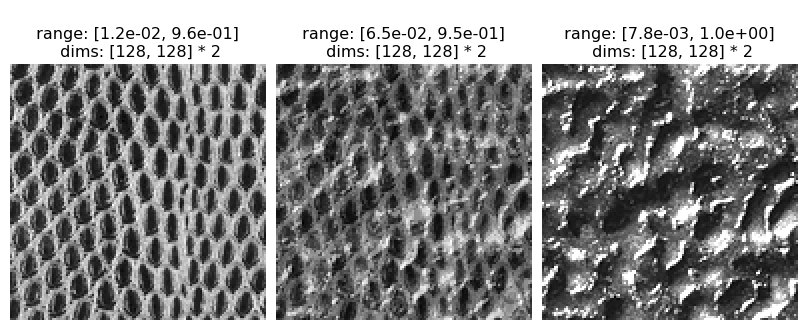

In [24]:
path = '../data/'
nameA = 'reptil_skin'
nameB = 'metal'

imageA = plt.imread(path + nameA + '.pgm') / 255.
imageB = plt.imread(path + nameB + '.pgm') / 255.

c = 64
imageA = imageA[c:-c, c:-c]
imageB = imageB[c:-c, c:-c]
pt.image_stats(imageA)
pt.image_stats(imageB)

imgSize = imageA.shape[0]
pt.imshow([imageA, (imageA + imageB)/2, imageB], vrange='indep1', zoom=2);

In [25]:
imgA = torch.tensor(imageA, dtype=dtype).unsqueeze(0).unsqueeze(0)
imgB = torch.tensor(imageB, dtype=dtype).unsqueeze(0).unsqueeze(0)

print(imgA.shape)
from plenoptic.tools.straightness import make_straight_line
n_steps = 11
video = make_straight_line(imgA, imgB, n_steps)
print(video.shape)
pt.image_stats(po.to_numpy(video).squeeze())
pt.animshow(po.to_numpy(video).squeeze(), zoom=2)

torch.Size([1, 1, 128, 128])
torch.Size([11, 1, 128, 128])
Image statistics:
  Range: [0.007843, 1.000000]
  Mean: 0.411141,  Stdev: 0.204464,  Kurtosis: 2.656349


### spectral model

26

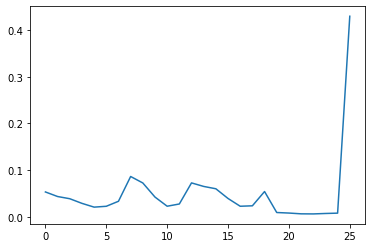

In [26]:
model = po.simul.Spectral(imgA.shape[-2:])
plt.plot(model(imgA)[0])
model.pyr.num_orientations * model.pyr.num_scales + 2

In [27]:
n_steps = 11
moog = po.synth.Geodesic(imgA, imgB, model, n_steps, init='straight', lmbda=.1)

print('shape trainable param', '# trainable param')
[p.shape for p in moog.parameters() if p.requires_grad], sum(p.numel() for p in moog.parameters() if p.requires_grad)

shape trainable param # trainable param


([torch.Size([9, 1, 128, 128])], 147456)

In [28]:
moog.synthesize(200, learning_rate=0.005)


 38%|███▊      | 75/200 [01:30<02:33,  1.23s/it, loss=2.0111e-04, gradient norm=1.6233e-03, lr=0.005]

KeyboardInterrupt: 

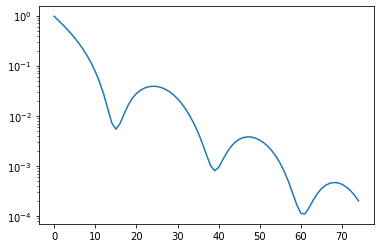

In [29]:
plt.plot(moog.loss)
plt.yscale('log')

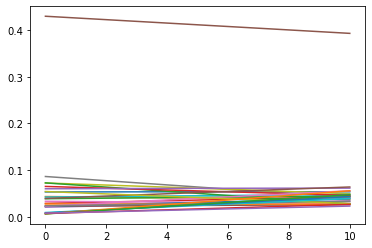

In [30]:
plt.plot(moog.model(moog.geodesic).squeeze());

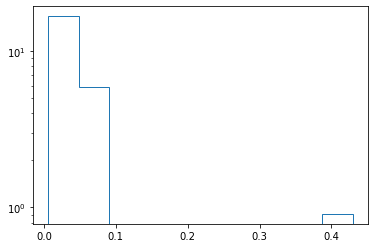

In [31]:
plt.hist(po.to_numpy(moog.model(moog.geodesic)).flatten(), histtype='step', density=True)
plt.yscale('log')

In [ ]:
# pt.animshow(po.to_numpy(moog.geodesic).squeeze(), framerate=11)

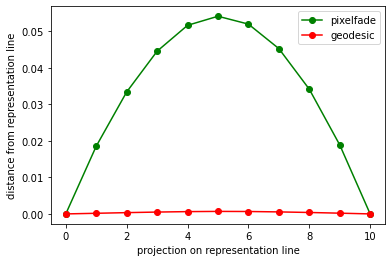

In [32]:
plt.plot(po.to_numpy(moog.distance_from_line(moog.pixelfade)), 'g-o', label='pixelfade')
plt.plot(po.to_numpy(moog.distance_from_line(moog.geodesic)), 'r-o', label='geodesic')
plt.legend(loc=1)
plt.ylabel('distance from representation line')
plt.xlabel('projection on representation line')
# plt.yscale('log')
plt.show()

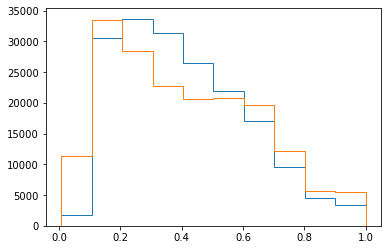

In [33]:
plt.hist(po.to_numpy(moog.pixelfade).flatten(), histtype='step')
plt.hist(po.to_numpy(moog.geodesic).flatten(), histtype='step');

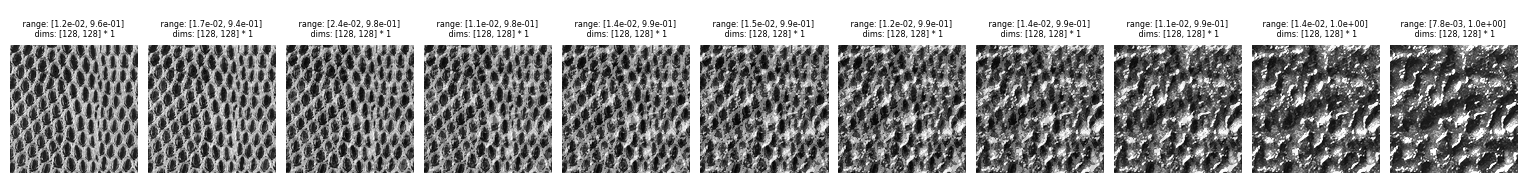

In [34]:
po.imshow(moog.geodesic);

In [ ]:
# pt.animshow([po.to_numpy(moog.geodesic).squeeze(), 
#             po.to_numpy(moog.pixelfade).squeeze()], framerate=11, repeat=True)

In [ ]:
po.imshow((moog.pixelfade - moog.geodesic)[1:-1], vrange='auto0');

In [ ]:
moog.reference_length

In [34]:
E = po.synth.Eigendistortion(imgA, model)

In [35]:
E.synthesize(tol=1e-5, n_steps=500)

Output dim: 31. Input dim: 16384
Power method -- computing the maximum distortion 

  0 -- delta_eigenval: 0.0000

Power method -- computing the minimum distortion 

  0 -- delta_eigenval: 0.9960
  1 -- delta_eigenval: 0.0001
  2 -- delta_eigenval: 0.0000


{'eigenvalues': tensor([1.0001, 0.0039]),
 'eigenvectors': [tensor([[-3.0292e-06, -1.1826e-06,  1.1881e-07,  ...,  3.2116e-06,
            3.7242e-06,  3.9624e-06],
          [ 4.5883e-06, -4.5850e-06, -1.8946e-06,  ..., -9.1018e-06,
            6.1820e-06,  6.1982e-06],
          [ 3.7211e-06, -4.7643e-06, -2.9868e-06,  ..., -2.4987e-05,
            5.9276e-06,  1.1856e-07],
          ...,
          [ 4.4372e-06,  7.8362e-08, -1.8043e-06,  ...,  6.1854e-06,
            5.7326e-06, -4.8166e-06],
          [ 4.4458e-06, -9.2790e-07, -3.1898e-06,  ..., -5.2412e-06,
           -2.5201e-06, -1.8885e-06],
          [-4.6962e-06, -4.8033e-06, -4.7854e-06,  ..., -1.8921e-05,
           -1.6187e-05,  4.3910e-06]]),
  tensor([[ 0.0061, -0.0118, -0.0108,  ...,  0.0047,  0.0046,  0.0046],
          [ 0.0041, -0.0068, -0.0120,  ...,  0.0052, -0.0005, -0.0001],
          [ 0.0046, -0.0101, -0.0007,  ...,  0.0006, -0.0021, -0.0110],
          ...,
          [ 0.0167,  0.0073,  0.0027,  ...,  0.0007,

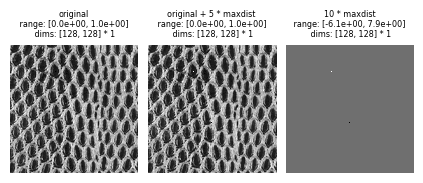

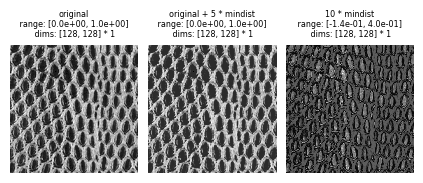

In [36]:
E.display()

In [37]:
M = po.synth.Metamer(imgA, model, loss_function='relative_MSE')

In [38]:
M.synthesize(optimizer='Adam', max_iter=1000, learning_rate=.05)

 10%|█         | 103/1000 [00:20<03:01,  4.94it/s, gradient_norm=2.4119e-04, learning_rate=0.05, loss=1.1139e-05]


(tensor([[[[0.2131, 0.3232, 0.2358,  ..., 0.1408, 0.1342, 0.1609],
           [0.1563, 0.1871, 0.2187,  ..., 0.1234, 0.1078, 0.1336],
           [0.2115, 0.5388, 0.2340,  ..., 0.1144, 0.3047, 0.2045],
           ...,
           [0.1562, 0.3055, 0.4936,  ..., 0.2629, 0.2335, 0.2011],
           [0.1527, 0.1872, 0.2604,  ..., 0.4442, 0.4073, 0.2683],
           [0.1718, 0.1972, 0.2471,  ..., 0.2574, 0.3124, 0.3560]]]]),
 tensor([[0.0546, 0.0609, 1.5733, 0.0085, 0.9610, 0.0529, 0.0429, 0.0389, 0.0283,
          0.0207, 0.0216, 0.0337, 0.0881, 0.0710, 0.0427, 0.0216, 0.0304, 0.0694,
          0.0660, 0.0586, 0.0396, 0.0217, 0.0246, 0.0519, 0.0096, 0.0086, 0.0064,
          0.0060, 0.0063, 0.0088, 0.4292]]))

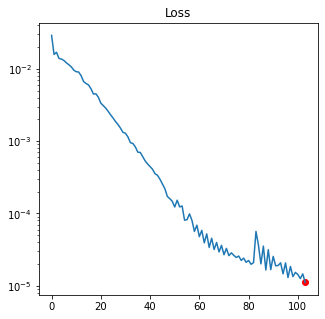

In [39]:
M.plot_loss();

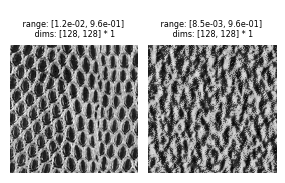

In [40]:
pt.imshow([imgA.squeeze(), po.to_numpy(M.synthesized_signal).squeeze()]);

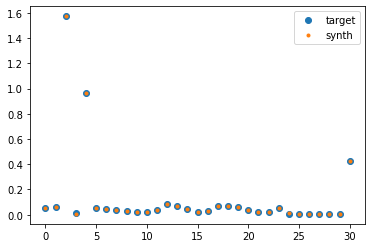

In [41]:
plt.plot(M.base_representation.detach().numpy().squeeze(), 'o', label='target')
plt.plot(M.synthesized_representation.detach().numpy().squeeze(), '.', label='synth')
plt.legend()
plt.show()

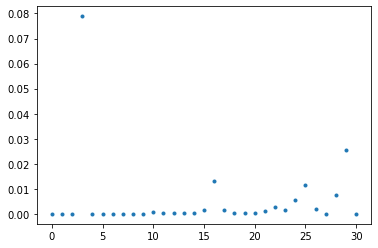

In [42]:
plt.plot((M.base_representation.detach().numpy().squeeze() - 
         M.synthesized_representation.detach().numpy().squeeze()) ** 2 /
         M.base_representation.detach().numpy().squeeze() ** 2, '.', label='synth')

### Texture Statistics Model

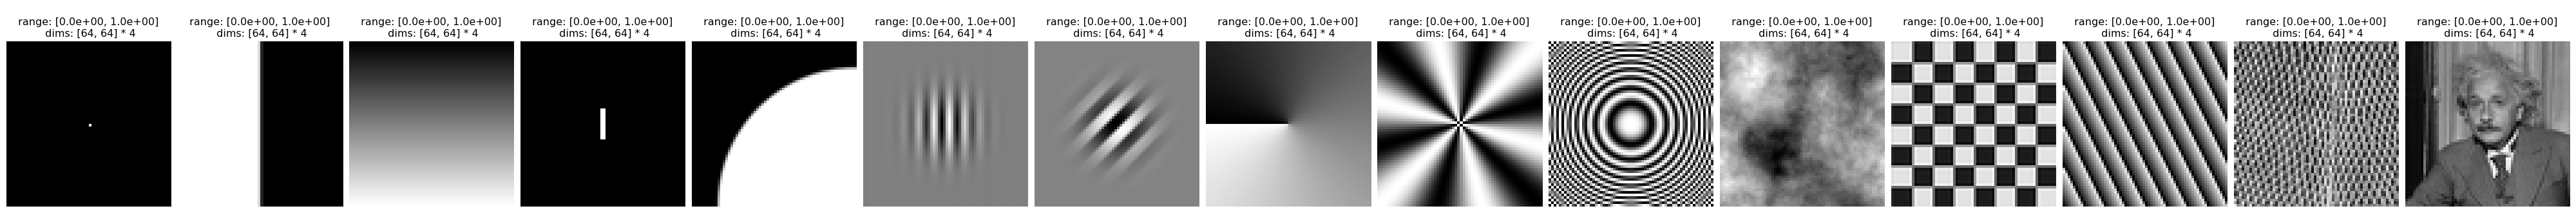

In [35]:
n = 64
x = po.make_basic_stimuli(n)

pyr = po.simul.Steerable_Pyramid_Freq(x.shape[-2:], height=4,
                                      is_complex=True, order=4-1,
                                      downsample=False)
y = pyr(x)
po.imshow(x, zoom=4);

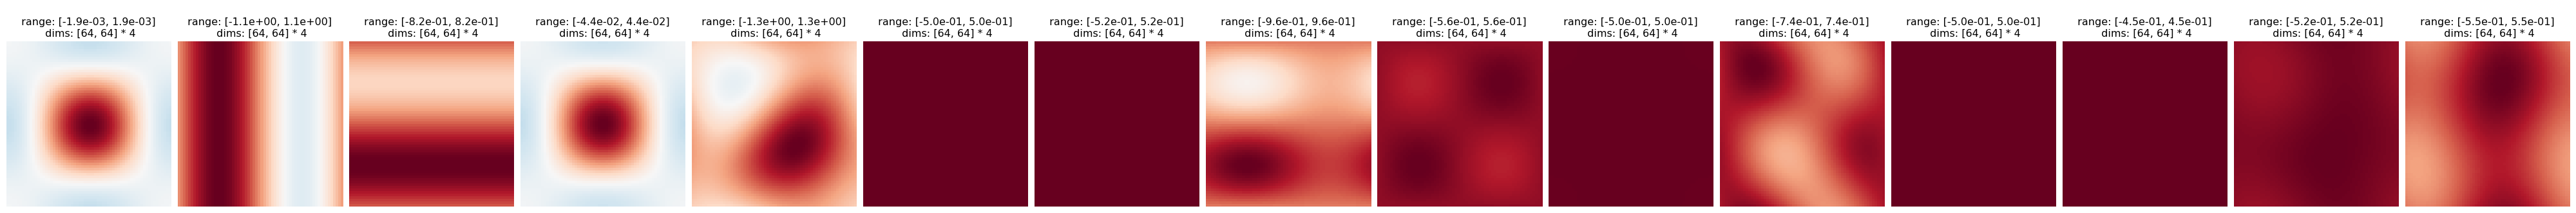

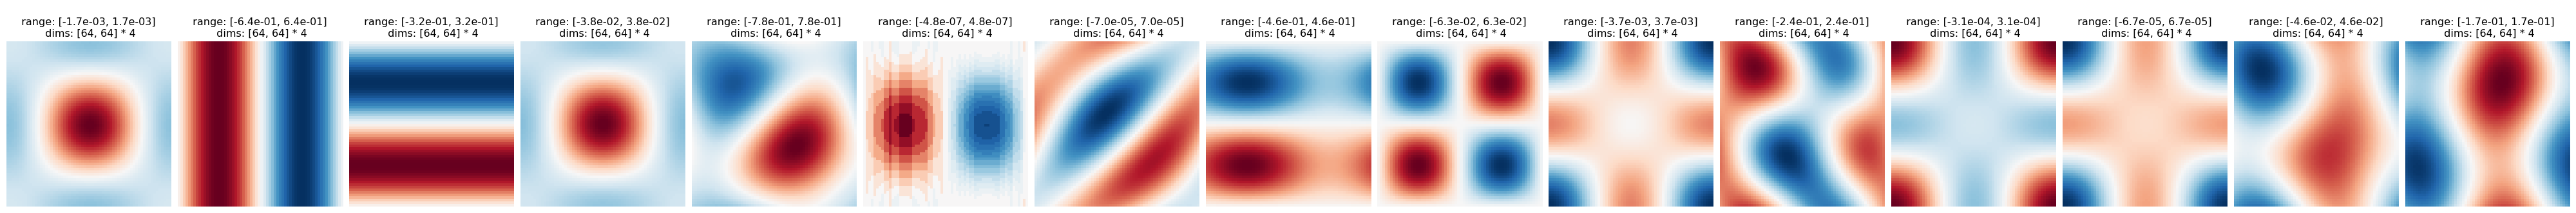

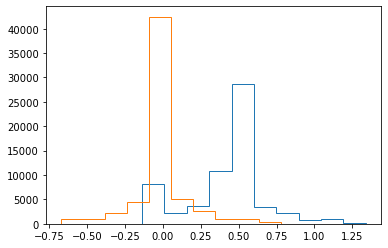

In [36]:
from einops import rearrange, reduce
# y[:, -1] -= 
reduce(y[:, -1], 'b h w -> b () ()', 'mean').squeeze()

po.imshow(y[:, -1], zoom=4, vrange='indep0');
po.imshow(y[:, -1] - reduce(y[:, -1], 'b h w -> b () ()', 'mean'),
          zoom=4, vrange='indep0');
plt.show()
plt.hist(po.to_numpy(y[:, -1].flatten()), histtype='step')
plt.hist(po.to_numpy((y[:, -1] -
  reduce(y[:, -1], 'b h w -> b () ()', 'mean')).flatten()), histtype='step');

In [37]:
energy, phase = po.rectangular_to_polar(y[:, 1:-1:2],
                                     y[:, 2:-1:2])
band_magnitude = torch.cat([torch.sqrt(y[:, 0:1]**2),
                            energy,
                            torch.sqrt(y[:, -1:]**2)],
                           dim=1)

y.shape, band_magnitude.shape

(torch.Size([15, 34, 64, 64]), torch.Size([15, 18, 64, 64]))

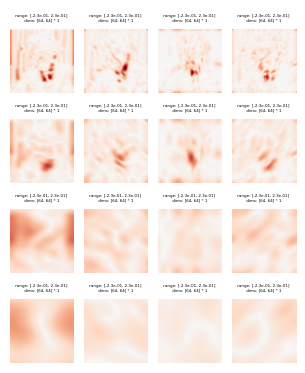

In [38]:
po.imshow(band_magnitude[-1][1:-1], col_wrap = 4, vrange='auto0');

In [39]:
band_magnitude_mean = reduce(band_magnitude,
                             'b c h w -> b c () ()', 'mean')
band_magnitude_mean.shape

torch.Size([15, 18, 1, 1])

In [40]:
# remove it, TODO squeeze after the substraction
band_magnitude -= band_magnitude_mean
band_magnitude_mean = rearrange(band_magnitude_mean, 'b c () () -> b c')

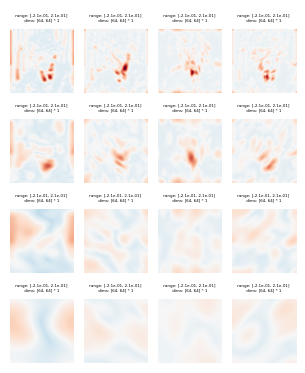

In [41]:
po.imshow(band_magnitude[-1][1:-1], col_wrap = 4, vrange='auto0');

In [42]:
TS = po.simul.models.Texture_Statistics(x.shape[-2:], 4, 4, 7)

In [43]:
stats = TS(x)
stats.shape

torch.Size([15, 1896])

In [44]:
# numpy dev

# j = 13
# im = po.to_numpy(x)[j]
# lowpass_residual = po.to_numpy(y[j,-1])
# h, w = lowpass_residual.shape

# # TODO with bare bones convolution
# p = pt.pyramids.SteerablePyramidFreq(lowpass_residual, 0 , 0)
# [c.shape for c in p.pyr_coeffs.values()]

# # lo = corrDn(image=self.image, filt=self.filters['lo0filt'], edge_type=self.edge_type)
# #         hi0 = corrDn(image=self.image, filt=self.filters['hi0filt'], edge_type=self.edge_type)

# y.shape

# po.imshow(y[:, -1] -
#           po.correlate_downsample(y, filt=pt.named_filter('sp1_filters')['lo0filt'], step=(1, 1))[:, -1], zoom=4, vrange='auto0');

# # TODO what?
# pt.imshow([lowpass_residual, 
#            p.pyr_coeffs['residual_highpass'],
#            p.pyr_coeffs['residual_lowpass']], zoom=4);

# s = min(h, w)
# n_scale = 4
# n_shifts = 7
# nth = np.log2(min(h, w)/n_shifts)
# nth, s

# if nth <= n_scale+1:
#     print(f'Warning: Na will be cut off for levels above {np.floor(nth+1)} !');

# ac = np.fft.fftshift(np.real(np.fft.ifft2(np.abs(np.fft.fft2(im))**2)))/(h*w)

# pt.imshow([im, ac], zoom=4);

# l = (n_shifts - 1)//2
# e = min(s/2 -1, l)
# l, e

# ch, cw = (h//2+1, w//2+1)
# ch

# ac.shape, e

# ch-e,ch+e,cw-e,cw+e
# # ac = ac(cy-le:cy+le,cx-le:cx+le);
# # acr(la-le+1:la+le+1,la-le+1:la+le+1,Nsc+1) = ac;

# pt.imshow(ac[ch-e:ch+e+1,cw-e:cw+e+1], zoom=8);

# n_batch = len(x)
# acr = torch.empty(n_batch, n_shifts, n_shifts, n_scale+1)
# acr.shape

# ac[ch-e:ch+e+1,cw-e:cw+e+1].shape, acr[:, l-e:l+e+1, l-e:l+e+1, n_scale].shape



# and now to torch

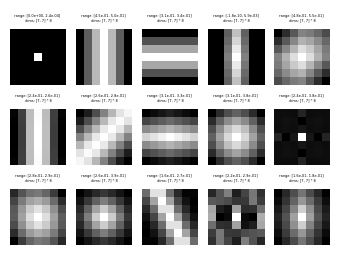

In [45]:
po.imshow(po.autocorr(x, 7), col_wrap=5, zoom=8, vrange='indep1');

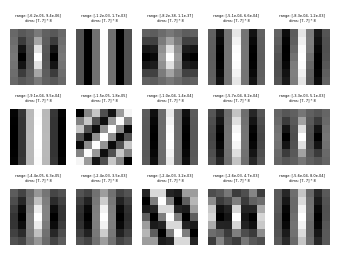

In [59]:
s = 0
po.imshow(po.autocorr(y, 7)[:, 1+8*s], col_wrap=5, zoom=8, vrange='indep1');

In [82]:
image_size = (64, 64)
n_scale = 4
n_ori = 4
pyr = po.simul.Steerable_Pyramid_Freq(image_size, height=n_scale,
                                          is_complex=True, order=n_ori-1,
                                          downsample=False)
y = pyr(x)
[c.shape for c in pyr.pyr_coeffs.values()]

[torch.Size([15, 1, 64, 64]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64, 2]),
 torch.Size([15, 1, 64, 64])]

In [81]:
abs_pyr_coeff = torch.cat([torch.sqrt(y[:, 0:1]**2),
                           energy,
                           torch.sqrt(y[:, -1:]**2)],
                          dim=1)
abs_pyr_coeff_mean = reduce(abs_pyr_coeff,
                            'b c h w -> b c () ()', 'mean')
abs_pyr_coeff -= abs_pyr_coeff_mean
abs_pyr_coeff_mean = rearrange(abs_pyr_coeff_mean,
                               'b c () () -> b c')

auto_corr_abs = po.autocorr(abs_pyr_coeff[:, 1:])
auto_corr_abs.shape

TypeError: unhashable type: 'slice'

In [237]:
# TODO
# construct unoriented pyr from Spyr

In [235]:
y = pyr(x)
pyr.pyr_coeffs = pyr.convert_tensor_to_pyr(y**2)
(x - pyr.recon_pyr()).flatten().pow(2).mean()

tensor(0.0950, grad_fn=<MeanBackward0>)

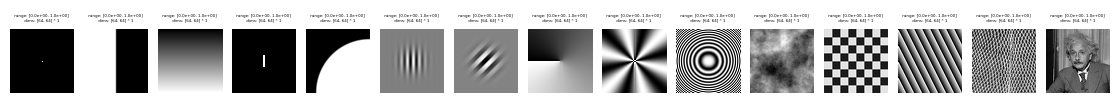

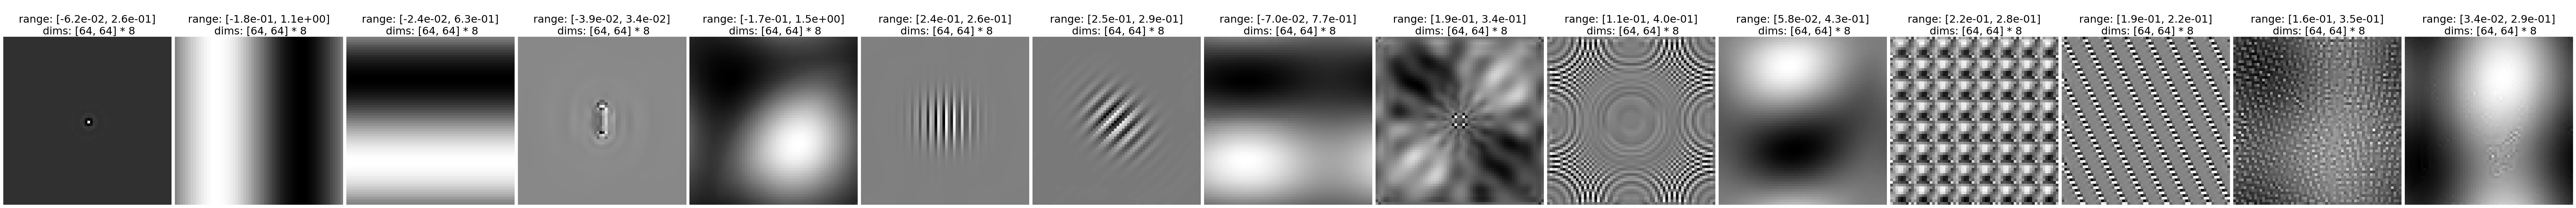

In [236]:
po.imshow(x, zoom=1)
po.imshow(pyr.recon_pyr(), zoom=8)

In [148]:
y[:,1::4].shape

torch.Size([15, 9, 64, 64])

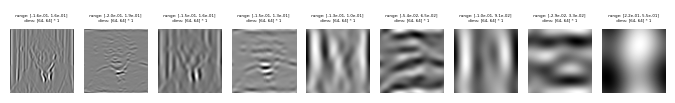

In [152]:
po.imshow(y[14,1::4])

In [156]:
y[14,1:5].sum(dim=0).shape

torch.Size([64, 64])

In [231]:
real_pyr_coeff = y[:, 1:-1:2]
real_pyr_coeff.shape

torch.Size([15, 16, 64, 64])

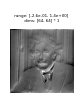

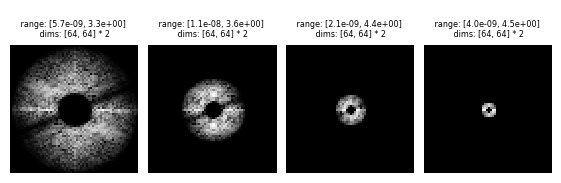

In [232]:
res = reduce(real_pyr_coeff, 'b (c1 c2) h w -> b c1 h w', 'sum', c1=4)

po.imshow(res[-1].sum(0) + y[-1, 0] + y[-1, -1])
po.imshow(np.log(1+np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy(res[-1]))), axes=(1, 2))),
          col_wrap=4, zoom=2)

# TODO
#y_lap = po.simul.Laplacian_Pyramid(4).analysis(x)
# print(len(y_lap), y_lap[-1].shape)
# po.imshow(np.log(1+np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy([y[-1] for y in y_lap]))), axes=(1, 2))),
#           col_wrap=4, zoom=2)

In [247]:
(torch.arange(5) - 1) / 2.

tensor([-0.5000,  0.0000,  0.5000,  1.0000,  1.5000])

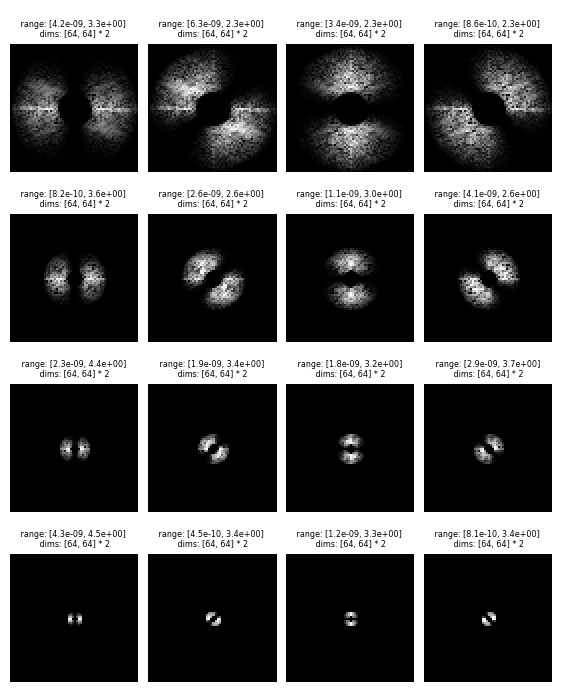

In [233]:
po.imshow(np.log(1+np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy(real_pyr_coeff[-1]))), axes=(1, 2))),
          col_wrap=4, zoom=2)

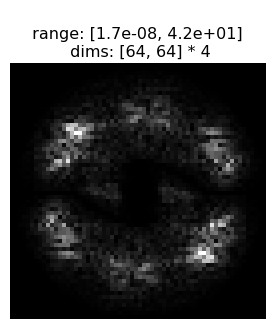

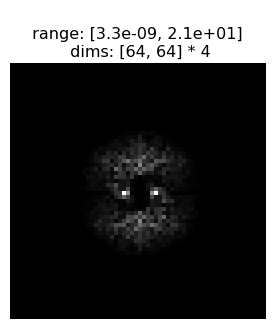

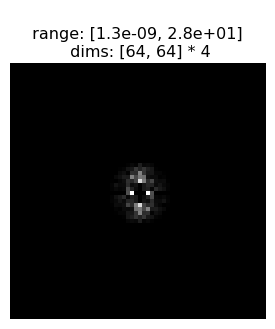

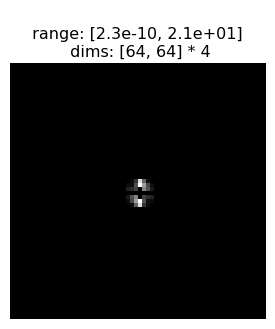

In [234]:
po.imshow(np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy(real_pyr_coeff[13,1:5].sum(0))))), zoom=4)
po.imshow(np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy(real_pyr_coeff[13,5:9].sum(0))))), zoom=4)
po.imshow(np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy(real_pyr_coeff[13,9:13].sum(0))))), zoom=4)
po.imshow(np.fft.fftshift(np.abs(np.fft.fft2(po.to_numpy(real_pyr_coeff[13,13:17].sum(0))))), zoom=4)